In [60]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [61]:
# Load BloodMNIST dataset
from medmnist import BloodMNIST

basic_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

train_dataset = BloodMNIST(split="train", transform=basic_transforms, download=True, size=28)
test_dataset = BloodMNIST(split="test", transform=basic_transforms, download=True, size=28)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [62]:
# information about the train_dataset
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\pande\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lice

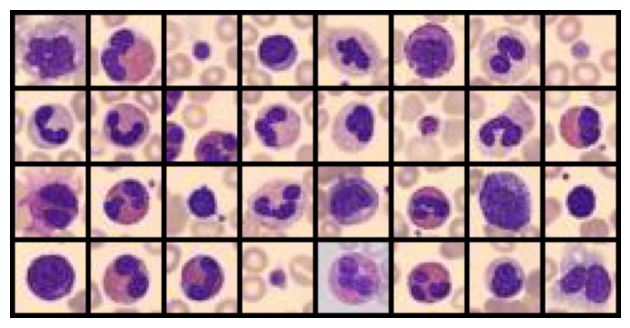

In [63]:
# visualise data
import torchvision.utils as vutils

# Get a batch of training images
images, labels = next(iter(train_loader))

# Create a grid of images
img_grid = vutils.make_grid(images[:32], nrow=8, normalize=True)

# Display the grid
plt.figure(figsize=(8, 4))
plt.imshow(img_grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis("off")
plt.show()


In [64]:
# Define data transformations
# basic_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_data_loaders(batch_size=64):
    """Downloads and prepares the BloodMNIST dataloaders."""
    train_dataset = BloodMNIST(split="train", transform=basic_transforms, download=True, size=28)
    test_dataset = BloodMNIST(split="test", transform=basic_transforms, download=True, size=28)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs):
    """A complete function to train and evaluate a given model."""
    model.to(device)
    
    # Training loop
    for epoch in range(epochs):
        model.train() # Set model to training mode
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))
            loss.backward()
            optimizer.step()
            
            loop.set_postfix(loss=loss.item())

    # Evaluation
    model.eval() # Set model to evaluation mode
    labels_list = []
    preds_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
    report=classification_report(y_true=labels_list, y_pred=preds_list)  
    print("\n--- Classification Report ---")
    print(report)
    print("-" * 55 + "\n")
    return accuracy_score(labels_list, preds_list)

In [65]:
baseline_accuracy = 0
def run_baseline_model():
    global baseline_accuracy
    print("Running Experiment: Baseline Model...")
    
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLP()
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    baseline_accuracy=train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_baseline_model()
print(f"Baseline Model Accuracy: {baseline_accuracy*100:.2f}%")

Running Experiment: Baseline Model...
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=8, bias=True)
  )
)


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 73.68it/s, loss=0.835]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.59      0.44      0.50       244
           1       0.80      0.80      0.80       624
           2       0.81      0.61      0.70       311
           3       0.54      0.60      0.57       579
           4       0.69      0.72      0.70       243
           5       0.49      0.36      0.42       284
           6       0.74      0.87      0.80       666
           7       0.94      0.99      0.96       470

    accuracy                           0.72      3421
   macro avg       0.70      0.67      0.68      3421
weighted avg       0.72      0.72      0.71      3421

-------------------------------------------------------

Baseline Model Accuracy: 72.05%


In [66]:
deeper_accuracy = 0
def run_deeper_model():
    global deeper_accuracy
    print("Running Experiment 1: Deeper Model (Increased Hidden Layers)...")

    class DeeperMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 64), nn.ReLU(),  # Additional layer
                nn.Linear(64, 32), nn.ReLU(),   # Additional layer
                nn.Linear(32, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = DeeperMLP()
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    deeper_accuracy=train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)

run_deeper_model()
print(f"Deeper Model Accuracy: {deeper_accuracy*100:.2f}%")

Running Experiment 1: Deeper Model (Increased Hidden Layers)...
DeeperMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=8, bias=True)
  )
)


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 65.59it/s, loss=1.19] 



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       244
           1       0.67      0.75      0.71       624
           2       0.74      0.51      0.61       311
           3       0.41      0.71      0.52       579
           4       0.81      0.48      0.60       243
           5       0.00      0.00      0.00       284
           6       0.66      0.87      0.75       666
           7       0.92      0.99      0.95       470

    accuracy                           0.64      3421
   macro avg       0.53      0.54      0.52      3421
weighted avg       0.57      0.64      0.59      3421

-------------------------------------------------------

Deeper Model Accuracy: 64.28%


x:\Edu\7th Sem\Neural Networks\(Lab) Neural Networks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Edu\7th Sem\Neural Networks\(Lab) Neural Networks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Edu\7th Sem\Neural Networks\(Lab) Neural Networks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [67]:
tanh_accuracy = 0
def run_tanh_activation_model():
    global tanh_accuracy
    print("Running Experiment 2: Changed Activation Function (Tanh)...")

    class MLPWithTanh(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.Tanh(), # Changed to Tanh
                nn.Linear(256, 128), nn.Tanh(),      # Changed to Tanh
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLPWithTanh()
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    tanh_accuracy=train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_tanh_activation_model()
print(f"Tanh Activation Model Accuracy: {tanh_accuracy*100:.2f}%")

Running Experiment 2: Changed Activation Function (Tanh)...
MLPWithTanh(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=256, bias=True)
    (2): Tanh()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=8, bias=True)
  )
)


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 69.34it/s, loss=0.747]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.73      0.23      0.34       244
           1       0.85      0.81      0.83       624
           2       0.74      0.68      0.71       311
           3       0.46      0.74      0.57       579
           4       0.70      0.72      0.71       243
           5       0.56      0.16      0.25       284
           6       0.79      0.85      0.82       666
           7       0.95      0.98      0.96       470

    accuracy                           0.72      3421
   macro avg       0.72      0.65      0.65      3421
weighted avg       0.73      0.72      0.70      3421

-------------------------------------------------------

Tanh Activation Model Accuracy: 71.56%


In [68]:
more_accuracy = 0
def run_more_epochs():
    global more_accuracy
    print("Running Experiment 3: Increased Epochs (15 Epochs)...")
    
    # Re-using the baseline MLP class
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLP()
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    more_accuracy=train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=15)
run_more_epochs()
print(f"More Epochs Model Accuracy: {more_accuracy*100:.2f}%")

Running Experiment 3: Increased Epochs (15 Epochs)...
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=8, bias=True)
  )
)


Epoch 15/15: 100%|██████████| 187/187 [00:02<00:00, 66.68it/s, loss=0.587]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.48      0.58       244
           1       0.92      0.93      0.93       624
           2       0.85      0.75      0.80       311
           3       0.58      0.76      0.66       579
           4       0.75      0.79      0.77       243
           5       0.70      0.52      0.60       284
           6       0.89      0.87      0.88       666
           7       0.97      0.99      0.98       470

    accuracy                           0.80      3421
   macro avg       0.80      0.76      0.77      3421
weighted avg       0.81      0.80      0.80      3421

-------------------------------------------------------

More Epochs Model Accuracy: 80.39%


In [69]:
adam_accuracy = 0
def run_adam_optimizer():
    global adam_accuracy
    print("Running Experiment 4: Using a Different Optimizer (Adam)...")

    # Re-using the baseline MLP class
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLP()
    print(model)
    criterion = nn.CrossEntropyLoss()
    # Using Adam with a smaller learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    adam_accuracy=train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_adam_optimizer()
print(f"Adam Optimizer Model Accuracy: {adam_accuracy*100:.2f}%")

Running Experiment 4: Using a Different Optimizer (Adam)...
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=8, bias=True)
  )
)


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 66.28it/s, loss=0.379]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       244
           1       0.97      0.92      0.95       624
           2       0.93      0.83      0.88       311
           3       0.61      0.77      0.68       579
           4       0.84      0.78      0.81       243
           5       0.73      0.59      0.65       284
           6       0.90      0.89      0.89       666
           7       0.99      0.99      0.99       470

    accuracy                           0.83      3421
   macro avg       0.83      0.80      0.81      3421
weighted avg       0.84      0.83      0.84      3421

-------------------------------------------------------

Adam Optimizer Model Accuracy: 83.31%


In [70]:
regu_accuracy = 0   
def run_regularized_model():
    global regu_accuracy
    print("Running Experiment 5: Using Normalization and Dropout...")

    class MLPWithRegularization(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256),
                nn.BatchNorm1d(256), # Batch Norm added
                nn.ReLU(),
                nn.Dropout(0.5),      # Dropout added (50% probability)
                nn.Linear(256, 128),
                nn.BatchNorm1d(128), # Batch Norm added
                nn.ReLU(),
                nn.Dropout(0.5),      # Dropout added (50% probability)
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLPWithRegularization()
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    regu_accuracy=train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_regularized_model()
print(f"Regularized Model Accuracy: {regu_accuracy*100:.2f}%")

Running Experiment 5: Using Normalization and Dropout...
MLPWithRegularization(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=8, bias=True)
  )
)


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 65.40it/s, loss=0.72] 



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       244
           1       0.95      0.93      0.94       624
           2       0.78      0.77      0.78       311
           3       0.61      0.71      0.66       579
           4       0.79      0.75      0.77       243
           5       0.68      0.57      0.62       284
           6       0.90      0.89      0.89       666
           7       0.98      0.99      0.99       470

    accuracy                           0.81      3421
   macro avg       0.79      0.77      0.78      3421
weighted avg       0.81      0.81      0.81      3421

-------------------------------------------------------

Regularized Model Accuracy: 81.18%


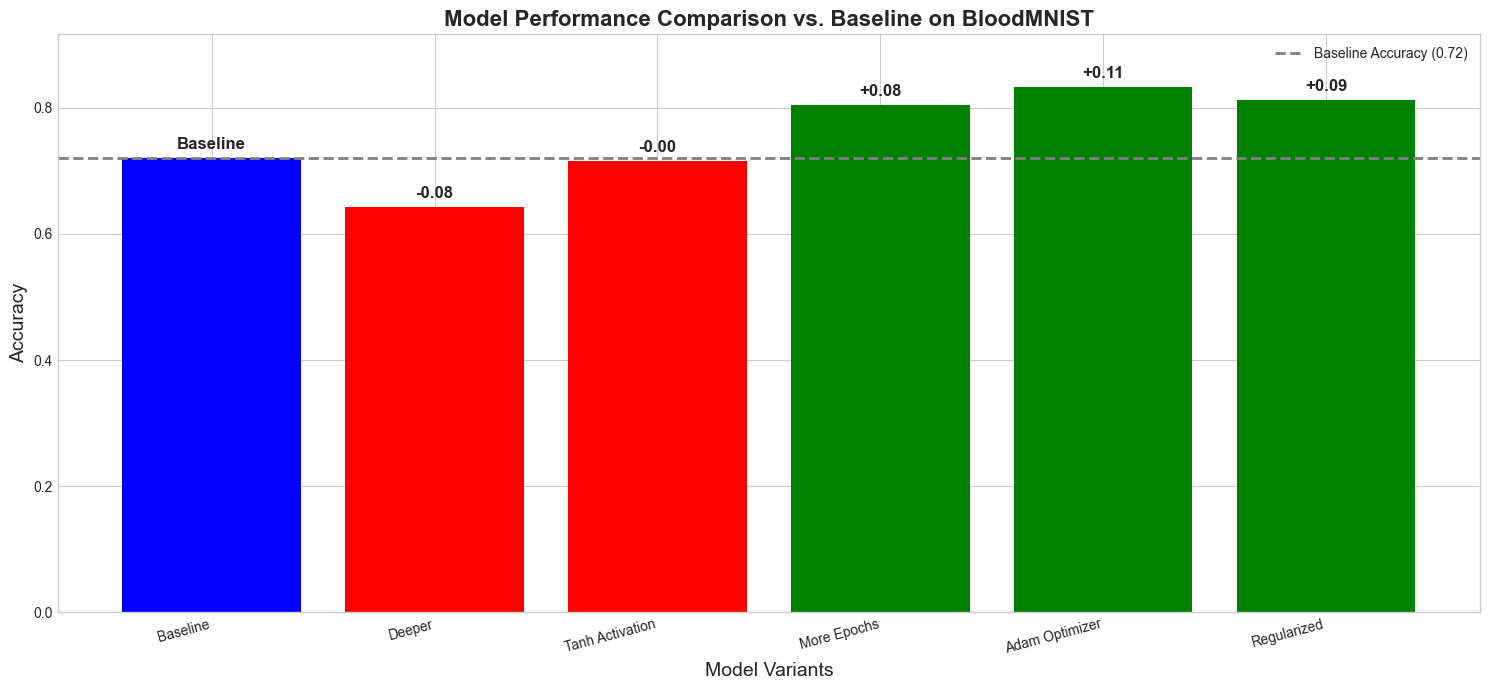

In [73]:

model_names = ['Baseline', 'Deeper', 'Tanh Activation', 'More Epochs', 'Adam Optimizer', 'Regularized']
accuracies = [baseline_accuracy, deeper_accuracy, tanh_accuracy, more_accuracy, adam_accuracy, regu_accuracy]
differences = [acc - baseline_accuracy for acc in accuracies]

colors = []
for diff in differences:
    if diff > 0:
        colors.append('green')
    elif diff < 0:
        colors.append('red')
    else:
        colors.append('blue') 

plt.style.use('seaborn-v0_8-whitegrid') 
fig, ax = plt.subplots(figsize=(15, 7))

bars = ax.bar(model_names, accuracies, color=colors)

ax.axhline(y=baseline_accuracy, color='grey', linestyle='--', linewidth=2, label=f'Baseline Accuracy ({baseline_accuracy:.2f})')

for bar, diff in zip(bars, differences):
    height = bar.get_height()
    
    if diff > 0:
        label = f'+{diff:.2f}'
    elif diff < 0:
        label = f'{diff:.2f}'
    else:
        label = 'Baseline'
        
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Model Variants', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Model Performance Comparison vs. Baseline on BloodMNIST', fontsize=16, fontweight='bold')
ax.set_ylim(0, max(accuracies) * 1.1) 
ax.legend()
plt.xticks(rotation=15, ha='right') 
plt.tight_layout()
plt.show()